## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import shutil
from scipy.spatial import Delaunay
import itertools
import ffmpeg

## Loading Images

In [2]:
img1 = cv.imread('res01.png')
img2 = cv.imread('res02.png')

In [3]:
print(img1.shape, img2.shape)

(638, 638, 3) (638, 638, 3)


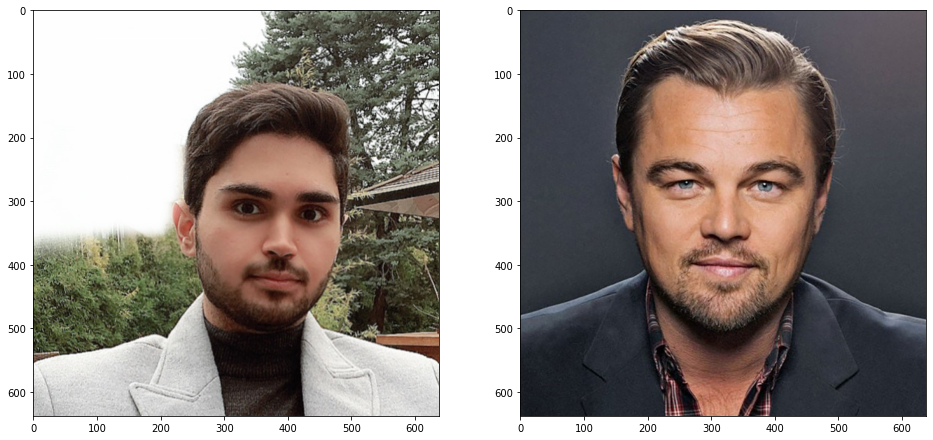

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB));

## Get Corresponding Feature Points

There are two files called `coords1.npy` and `coords2.npy` which are consist of corresponding feature points in the above images. Also you could run the commented code below in order to select your desired feature points as well. When you run that code block, the two images will be shown next to each other. Then you have to select some points in one, and the corresponding points in the other image. You can select $K_1$ points from the left one, the select the corresponding $K_1$ points in the right one. Then each time, do this for $K_i$ points and so on. You are not forced to select all the points from one image at once and you can do this for as many times as you want. Also note that the ordering of choosing points matter (the $j$th point in the left $K_i$ points should be corresponded to the $j$th points the right $K_i$ points)

(Note: You can change the `scale_factor` so that the image fits to your screen and select points better)

In [5]:
def get_points(source_img_input, scale_factor=1.5):
    source_img = cv.resize(
        source_img_input,
        (int(source_img_input.shape[1] * scale_factor), int(source_img_input.shape[0] * scale_factor)),
        interpolation=cv.INTER_AREA
    )
    
    def draw_circle(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            if x < source_img.shape[1]//2:
                if [y, x] not in coords1: # Due to mouse problems and multiple clicks
                    coords1.append([y, x])
            else:
                if [y, x-source_img.shape[1]//2] not in coords2: # Due to mouse problems and multiple clicks
                    coords2.append([y, x-source_img.shape[1]//2])
            cv.circle(img, (x, y), int(2*scale_factor), (0, 0, 255), -1)
            cv.imshow('image', img)

    coords1, coords2 = [], []
    img = source_img.copy()
    cv.namedWindow('image')
    cv.setMouseCallback('image', draw_circle)
    cv.imshow('image', img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return np.int32(np.array(coords1)/scale_factor), np.int32(np.array(coords2)/scale_factor)

In order to select the points manually, uncomment the below cell and run it.

In [6]:
# coords1, coords2 = get_points(np.concatenate([img1, img2], axis=1))

# # Adding corners
# corners_coord = np.array(list(
#     itertools.product(*[[0, img1.shape[0]], [0, img1.shape[1]]])
# ))
# coords1 = np.concatenate([coords1, corners_coord])
# coords2 = np.concatenate([coords2, corners_coord])

# np.save('coords1.npy', coords1)
# np.save('coords2.npy', coords2)

In [7]:
coords1 = np.load('coords1.npy')
coords2 = np.load('coords2.npy')

In [8]:
def draw_points(img, points):
    res = img.copy()
    for y, x in points:
        cv.circle(res, (x, y), 4, (0, 0, 255), -1)
    return res

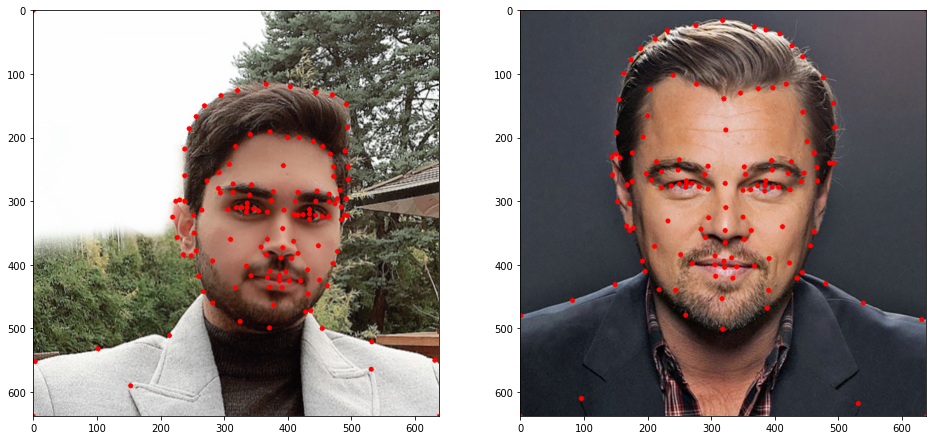

In [9]:
tmp1, tmp2 = draw_points(img1, coords1), draw_points(img2, coords2)

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].imshow(cv.cvtColor(tmp1, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(tmp2, cv.COLOR_BGR2RGB));

At this point, we have the corresponding feature points in both images. now we need to make a triangulation. A triangulation of set of points in the plane is a partition of the convex hull to triangles whose vertices are the points, and do not contain other points. For doing this, we use Delaunay Triangulation using `scipy.spatial.Delaunay`.

In [10]:
tri = Delaunay(coords1[:, [1, 0]])

We do this triangulation only on one image and since we have the correspoing points in the other image, using this triangulation, we can have the triangulation for the second image as well.

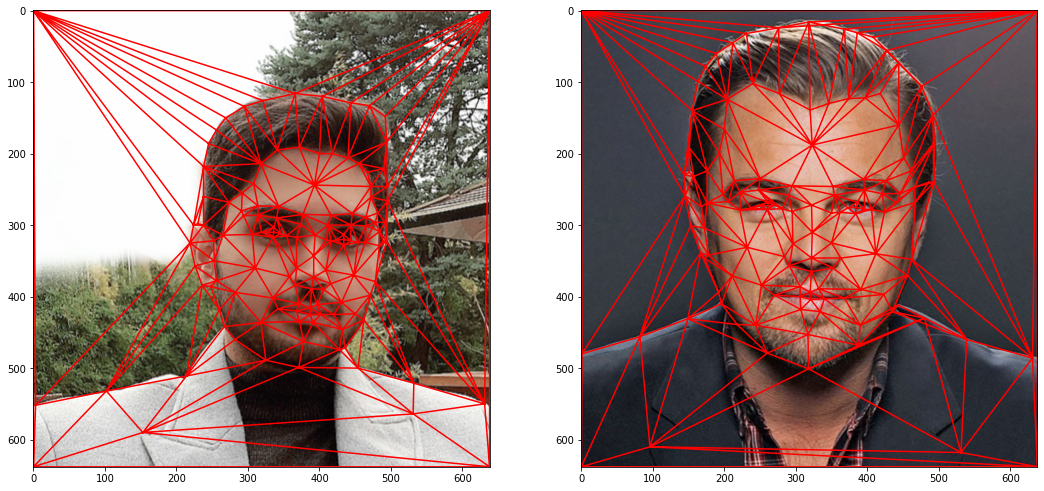

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10))
axs[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axs[0].triplot(coords1[:, 1], coords1[:, 0], tri.simplices, color='red')
axs[0].margins(0)
axs[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
axs[1].triplot(coords2[:, 1], coords2[:, 0], tri.simplices, color='red');
axs[1].margins(0)


## Morphing

Now, we have corresponding triangles in the twow images. 

Generally, we have two steps in morphing (in each frame):
- Warping (for getting the shape)
- Cross-Dissolving (for the color) 

in each step for $t$ $(0 \leq t \leq 1)$ (which you can think of $t$ as $t = \frac{i}{N}$ where $i$ is the frame number and $N$ is the total number of frames), for each pair of corresponding triangles (call this $T_1$ and $T_2$), we build another triangle (call it $T_3$) using the weighted average of that pair with weights $t$ and $1-t$ (this is the warping step). Now for each $T_3$, we find an affine projection to it's corresponding $T_1$ and $T_2$. Using this transformation, we can find out that where each pixel in $T_3$ mapped from $T_1$ and $T_2$. We use a weighted average of pixel colors in $T_1$ and $T_2$ (using weights $t$ and $1-t$) to get the color value for each pixel in triangles of $T_3$ (this is the cross-dissolving step).

<br>

**Explanation of weighted average of points:**

assume that we have two points called $P$ and $Q$ and set $V$ to the vector $Q - P$. If we take a $t$ where $0 \leq t \leq 1$, and calculate $P + t \times V$ (or $P + t(Q-P)$ equivalently) we would get a point in betwewen, inside the line connecting these two points.

In [12]:
def triangle_weighted_avg(t1, t2, alpha):
    return t1 + alpha*(t2-t1)

This function creates a binary mask for a specific triangle

In [13]:
def get_triangle_mask(shape, t_points):
    return cv.drawContours(
        np.zeros(shape, dtype=int),
        [t_points[:, [1, 0]].astype(int)],
        0, 1, -1
    ).astype(bool)

Now, to ensure that we are on the right track, let's test this for a single triangle (in both images) and calculate it's weighted average triangle and use `cv.getAffineTransform` and `cv.warpAffine` to get the transformed triangels (transformation of $T_1$ and $T_2$ to $T_3$)

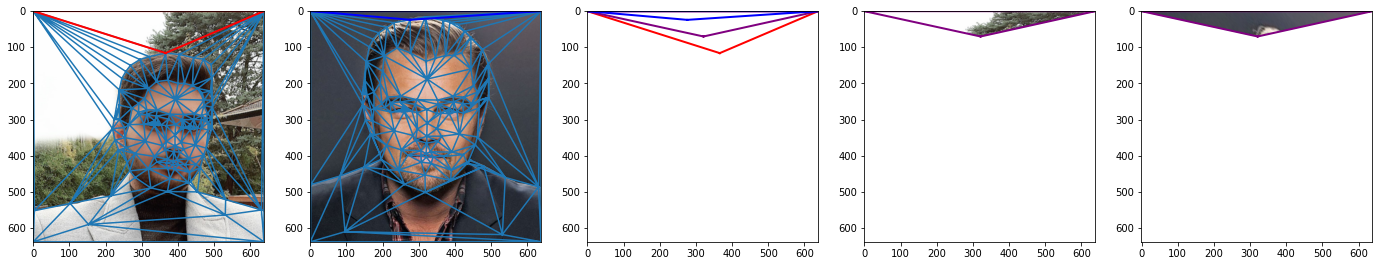

In [14]:
# Get a single triangle in both images
idx = 0
T1 = coords1[tri.simplices][idx]
T2 = coords2[tri.simplices][idx]

# Calculate the weighted average triangle
T3 = triangle_weighted_avg(T1, T2, 0.5)

img_tmp1 = np.full_like(img1, 255)
img_tmp2 = np.full_like(img1, 255)
mask = get_triangle_mask(img1.shape[:2], T3) # Binary Mask for T3

# Find Affine Transformation for T1
T = cv.getAffineTransform(T1[:, [1, 0]].astype(np.float32), T3[:, [1, 0]].astype(np.float32))
img_tmp1[mask] = cv.warpAffine(img1, T, img_tmp1.shape[:2][::-1])[mask]
    
# Find Affine Transformation for T2
T = cv.getAffineTransform(T2[:, [1, 0]].astype(np.float32), T3[:, [1, 0]].astype(np.float32))
img_tmp2[mask] = cv.warpAffine(img2, T, img_tmp2.shape[:2][::-1])[mask]
    

# Plotting the results
fig, axs = plt.subplots(1, 5, figsize=(24, 10))
axs[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axs[0].triplot(coords1[:, 1], coords1[:, 0], tri.simplices)
axs[0].triplot(T1[:, 1], T1[:, 0], color='red', lw=2);
axs[0].margins(0)

axs[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
axs[1].triplot(coords2[:, 1], coords2[:, 0], tri.simplices);
axs[1].triplot(T2[:, 1], T2[:, 0], color='blue', lw=2);
axs[1].margins(0)

axs[2].imshow(np.full_like(img1, 255))
axs[2].triplot(T1[:, 1], T1[:, 0], color='red', lw=2);
axs[2].triplot(T3[:, 1], T3[:, 0], color='purple', lw=2);
axs[2].triplot(T2[:, 1], T2[:, 0], color='blue', lw=2);
axs[2].margins(0)

axs[3].imshow(cv.cvtColor(img_tmp1, cv.COLOR_BGR2RGB))
axs[3].triplot(T3[:, 1], T3[:, 0], color='purple', lw=2);
axs[3].margins(0)

axs[4].imshow(cv.cvtColor(img_tmp2, cv.COLOR_BGR2RGB))
axs[4].triplot(T3[:, 1], T3[:, 0], color='purple', lw=2);
axs[4].margins(0)


Ok, now let's use the above implementations and the method's description to make all the frames (for each $t$ where $t=\frac{i}{N}$)

In [15]:
num_frames = 45

frames = []

for alpha in np.linspace(0, 1, num_frames):
    frame_result = np.zeros_like(img1)

    for idx in range(tri.simplices.shape[0]):
        t1 = coords1[tri.simplices][idx]
        t2 = coords2[tri.simplices][idx]

        t_avg = triangle_weighted_avg(t1, t2, alpha)

        t_mask = get_triangle_mask(img1.shape[:2], t_avg)

        T1 = cv.getAffineTransform(t1[:, [1, 0]].astype(np.float32), t_avg[:, [1, 0]].astype(np.float32))
        T2 = cv.getAffineTransform(t2[:, [1, 0]].astype(np.float32), t_avg[:, [1, 0]].astype(np.float32))
        
        frame_result[t_mask] = (1-alpha)*cv.warpAffine(img1, T1, frame_result.shape[:2][::-1])[t_mask] + alpha*cv.warpAffine(img2, T2, frame_result.shape[:2][::-1])[t_mask]

    frames.append(frame_result)

Let's take a look at some of the frames

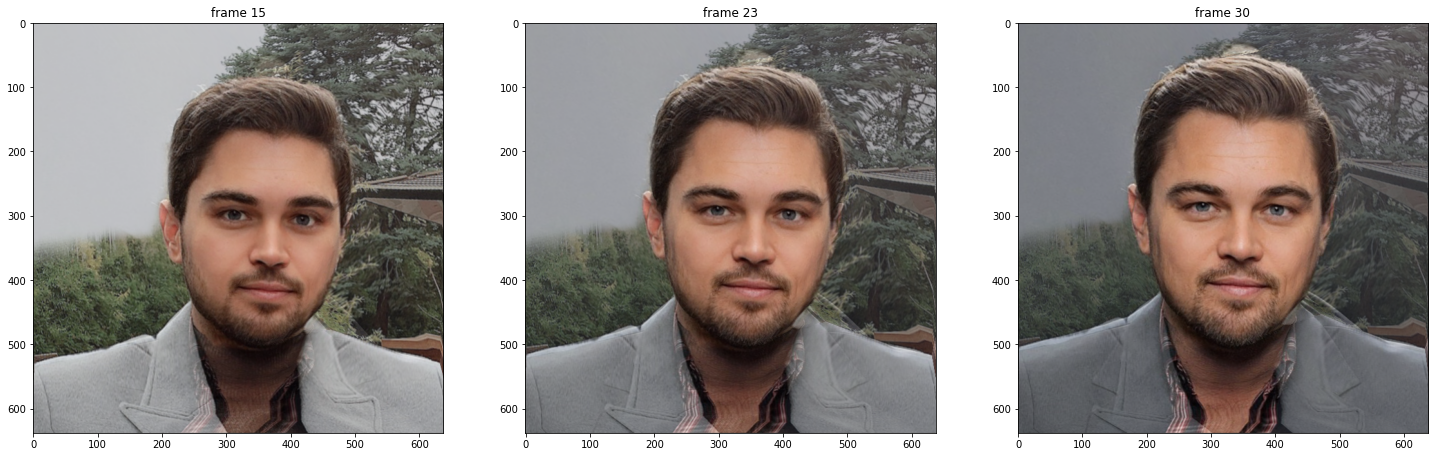

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(25, 15))
for i, frame_num in enumerate([14, 22, 29]):
    axs[i].imshow(cv.cvtColor(frames[frame_num], cv.COLOR_BGR2RGB))
    axs[i].set_title(f"frame {frame_num+1}")

Using these frames, let's make a video from them

In [23]:
dir_name = "temp_video_images"
os.mkdir(dir_name)
for idx, image in enumerate(frames):
    cv.imwrite(f"{dir_name}/{idx if idx > 9 else f'0{idx}'}.jpg", image)
for idx, image in enumerate(frames[::-1]):
    cv.imwrite(f"{dir_name}/{num_frames+idx}.jpg", image)

(
    ffmpeg
    .input(f'{dir_name}/%2d.jpg', framerate=20)
    .output('morph.mp4')
    .overwrite_output()
    .global_args('-loglevel', 'quiet')
    .run(capture_stdout=True, capture_stderr=True)
)

shutil.rmtree(dir_name)

In [24]:
from IPython.display import Video
Video("morph.mp4")